In [282]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns

WORK_SPACE = "/home/olle/PycharmProjects/LODE/workspace"

longitudinal_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/longitudinal_data.csv"))
segmentation_statistics_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/segmentation_statistics_vol.csv"))

#### pre process columns

In [283]:
id_cols = segmentation_statistics_pd.record.str.split("_", expand=True)[[0, 1 , 2, 3]]

segmentation_statistics_pd["patient_id"] = id_cols[0]
segmentation_statistics_pd["study_date"] = id_cols[1]
segmentation_statistics_pd["laterality"] = id_cols[2]

longitudinal_pd["study_date"] = longitudinal_pd.study_date.str.replace("-", "")

In [284]:
# cast data types
keys = ["patient_id", "study_date", "laterality"] 
for key in keys:
    longitudinal_pd[key] = longitudinal_pd[key].astype(str)
    segmentation_statistics_pd[key] = segmentation_statistics_pd[key].astype(str)

#### merge

In [285]:
longitudinal_abt = pd.merge(longitudinal_pd, segmentation_statistics_pd, how="inner", 
                            left_on = keys, right_on = keys)

feature_columns = list(longitudinal_abt.columns[17:])

#### correlation table

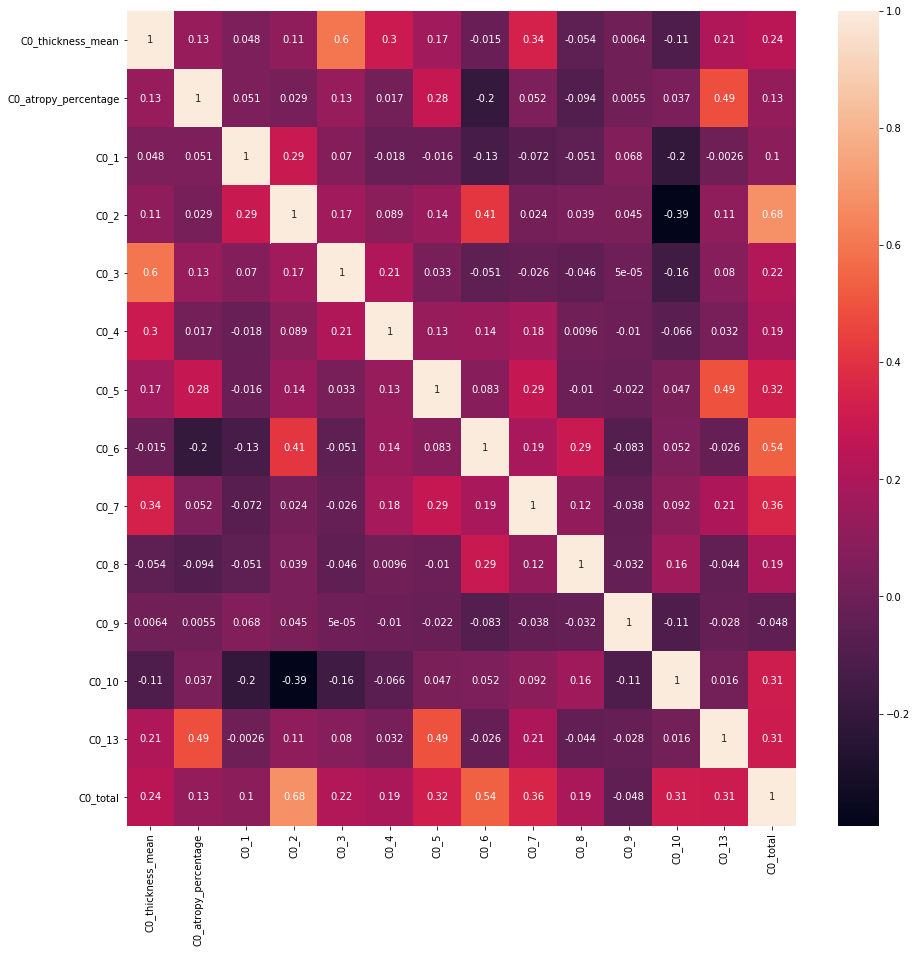

In [286]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

fovea_feature_columns = [feature for feature in feature_columns if "C0" in feature]
corrMatrix = longitudinal_abt[fovea_feature_columns].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### plot absolute effect for 3, 6, 12 months

In [287]:
time_2_dry_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/time_until_dry.csv"))

In [288]:
time_2_dry_pd[time_2_dry_pd.patient_id == 1570]

,Unnamed: 0,patient_id,laterality


In [289]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="whitegrid")
sns.scatterplot(data=time_2_dry_pd, x="abs1_3", y="abs1_6")

ValueError: Could not interpret value `abs1_3` for parameter `x`

In [ ]:
effect_month = time_2_dry_pd[["abs1_3", "abs1_6", "abs1_12"]]

# rename columns for plotting
effect_month = effect_month.rename(columns={"abs1_3": "3", "abs1_6": "6", "abs1_12": "12"})

# make table long
effect_month_long = pd.melt(effect_month, value_vars=["3", "6", "12"], 
        var_name = "time", value_name = "effect")


effect_month_rel = time_2_dry_pd[["rel1_3", "rel1_6", "rel1_12"]]

# rename columns for plotting
effect_month_rel = effect_month_rel.rename(columns={"rel1_3": "3", "rel1_6": "6", "rel1_12": "12"})

# make table long
effect_month_rel_long = pd.melt(effect_month_rel, value_vars=["3", "6", "12"], 
        var_name = "time", value_name = "effect")

In [ ]:
#### aggregated statistics over data frames

In [ ]:
summary_stats = pd.DataFrame([effect_month.mean(axis=0), effect_month.std(axis=0)]).T
summary_stats = summary_stats.rename(columns={0:"mean", 1:"std"})
summary_stats

#### compare relative changes

In [ ]:
effect_month_rel = effect_month_rel.replace([np.inf, -np.inf], np.nan)
summary_stats = pd.DataFrame([effect_month_rel.mean(0, skipna=True), effect_month_rel.std(axis=0)]).T
summary_stats = summary_stats.rename(columns={0:"mean", 1:"std"})
summary_stats

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="time", y="effect", data=effect_month_long)
ax = sns.stripplot(x="time", y="effect", data=effect_month_long, alpha=0.5)
plt.title("Treatment effect across time delta")
ax.set(xlabel="3, 6, and 12 month interval since first injection", 
       ylabel="treatment effect measured in cubic mm")

#### Effect cross injections plot

In [ ]:
month3 = pd.melt(time_2_dry_pd[["abs1_3", "inj1_3"]], id_vars=["inj1_3"], value_vars=["abs1_3"])
month6 = pd.melt(time_2_dry_pd[["abs1_6", "inj1_6"]], id_vars=["inj1_6"], value_vars=["abs1_6"])
month12 = pd.melt(time_2_dry_pd[["abs1_12", "inj1_12"]], id_vars=["inj1_12"], value_vars=["abs1_12"])

month3 = month3.rename(columns={"inj1_3": "inj"})
month6 = month6.rename(columns={"inj1_6": "inj"})
month12 = month12.rename(columns={"inj1_12": "inj"})

effect_injections = month3.append(month6).append(month12)

In [ ]:
sns.lineplot(data=effect_injections, x="inj", y="value")
ax = sns.scatterplot(data=effect_injections, x="inj", y="value")
plt.title("Treatment effect as a function of number of injections")
ax.set(xlabel="number of injections administrered", 
       ylabel="treatment effect from first measurement measured in cubic mm")